In [20]:
# https://goo.gl/skM3Ed
import mdai
import os
mdai.__version__

'0.0.5'

In [3]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="cab187e530482790d5ac6f9769aa260d")

Successfully authenticated to public.md.ai.


In [4]:
p = mdai_client.project('PVq9raBJ', path='../data/raw/lesson1-data')

Using path '../data/raw/lesson1-data' for data.
Preparing annotations export for project PVq9raBJ...                                                
Preparing images export for project PVq9raBJ...                                                     
Using cached images data for project PVq9raBJ.
Using cached annotations data for project PVq9raBJ.


In [5]:
p.show_label_groups()

Label Group, Id: G_3lv, Name: Default group
	Labels:
	Id: L_yxv, Name: Abdomen
	Id: L_dyy, Name: Chest



In [6]:
# this maps label ids to class ids as a dict obj# this  
labels_dict = {'L_yxv':0, # Abdomen 
               'L_dyy':1, # Chest  
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_yxv': 0, 'L_dyy': 1}
None
None


In [7]:
p.show_datasets()

Datasets:
Id: D_33v, Name: TRAIN
Id: D_vvp, Name: VAL
Id: D_oz1, Name: TEST



In [8]:
# create training dataset # creat 
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()
print(len(train_image_ids))

# create the validation dataset 
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()
print(len(val_image_ids))

65
10


Input image pixel range exceeds 255, rescaling for visualization.


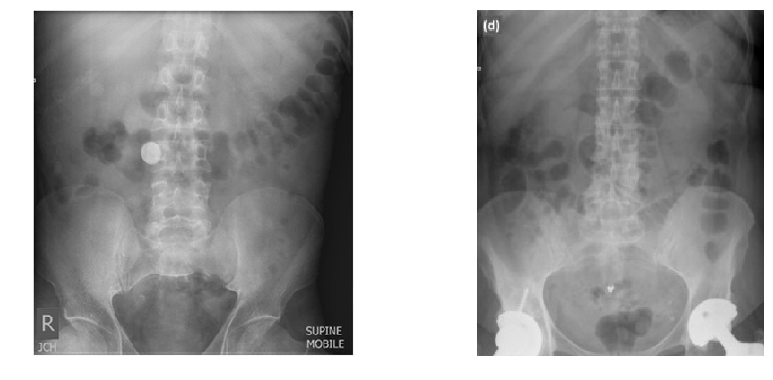

Input image pixel range exceeds 255, rescaling for visualization.


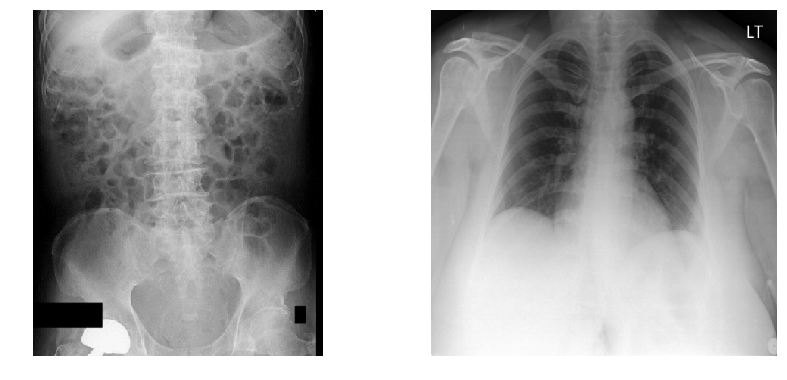

In [9]:
# visualize a few train images # visua 
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

In [10]:
from keras import applications
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.
/Users/ylchen/.virtualenvs/kaggle-rsna/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
# Define model parameters 
img_width = 192
img_height = 192
epochs = 20

params = {
    'dim': (img_width, img_height),
    'batch_size': 5,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

In [12]:
base_model = applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from mdai.utils import keras_utils

train_generator = keras_utils.DataGenerator(train_dataset, **params)
val_generator = keras_utils.DataGenerator(val_dataset, **params)

In [14]:
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [15]:
# Set callback functions to early stop training and save the best model so far
model_filepath = os.path.join('..', 'model', 'lesson1', 'best_model.h5')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=2),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=True, 
            workers=6)

Epoch 1/20
13/13 [==============================] - 27s 2s/step - loss: 0.5108 - acc: 0.7692 - val_loss: 0.3107 - val_acc: 0.8000

Epoch 00001: val_loss improved from inf to 0.31067, saving model to best_model.h5
Epoch 2/20
13/13 [==============================] - 19s 1s/step - loss: 0.0736 - acc: 0.9692 - val_loss: 0.1842 - val_acc: 0.8000

Epoch 00002: val_loss improved from 0.31067 to 0.18420, saving model to best_model.h5
Epoch 3/20
13/13 [==============================] - 19s 1s/step - loss: 0.1167 - acc: 0.9231 - val_loss: 0.0646 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.18420 to 0.06459, saving model to best_model.h5
Epoch 4/20
13/13 [==============================] - 19s 1s/step - loss: 0.2437 - acc: 0.9538 - val_loss: 0.0270 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.06459 to 0.02697, saving model to best_model.h5
Epoch 5/20
13/13 [==============================] - 19s 1s/step - loss: 0.0219 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 1.0000

Epoch

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


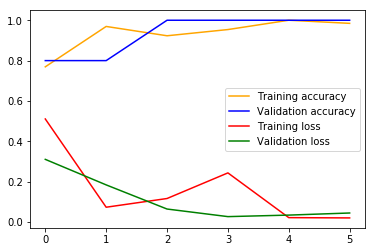

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

In [21]:
model.load_weights(model_filepath)

In [18]:
test_dataset = p.get_dataset_by_name('TEST')
test_dataset.prepare()

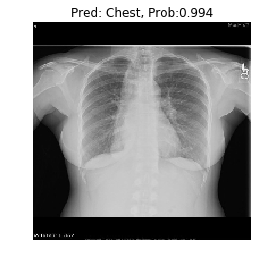

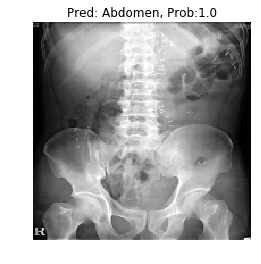

In [19]:
import numpy as np
#from skimage.transform import resize
from PIL import Image 

for image_id in test_dataset.image_ids: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()